In [92]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [93]:
import cv2
import numpy as np
import imutils
from imutils.perspective import four_point_transform
import matplotlib.pyplot as plt
import numpy as json
import matplotlib.pyplot as json
from google.colab import drive
import easyocr
import csv

In [94]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


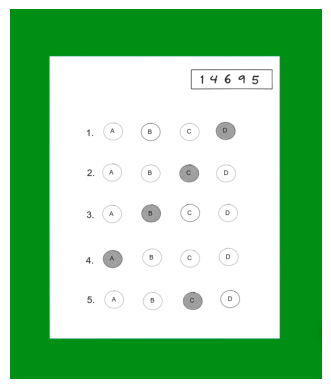

In [95]:
# Define the image path
image_path = '/content/drive/MyDrive/bubble9.png'

# Reading the image using OpenCV
image = cv2.imread(image_path)

# Checks if the image is loaded successfully
if image is not None:
    # Converts the BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
else:
    print("Error: Unable to load the image.")


## Edge Detection


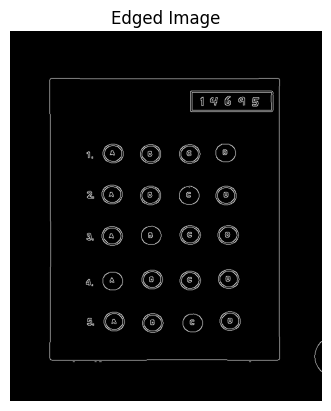

In [96]:
# Load the image and preprocess
image_path = "/content/drive/MyDrive/bubble9.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhancing contrast using histogram equalization
equalized = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 150)

# Finds contours and detect document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            docCnt = approx
            break

if docCnt is not None:
    # If a document contour is detected, performs a perspective transform
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped_gray = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)
else:
    print("[ERROR] Could not find the document contour.")

# Visualize edged image
plt.imshow(edged, cmap='gray')
plt.title("Edged Image")
plt.axis('off')
plt.show()

## Bubble Detection




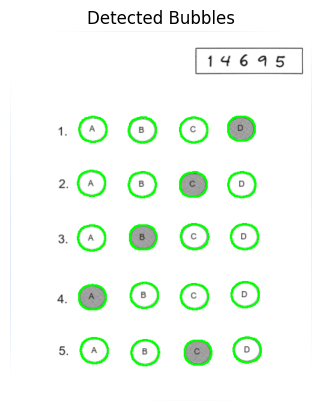

In [97]:
# using 'warped_gray' from the previous code
equalized = cv2.equalizeHist(warped_gray)
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 150)

# Finding contours in the edged image
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
bubble_cnts = []

# Filter out contours that correspond to bubbles
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    aspect_ratio = w / float(h)
    area = cv2.contourArea(c)

    # Criteria for bubbles
    if 0.8 <= aspect_ratio <= 1.2 and 200 < area < 1500:
        circularity = (4 * np.pi * area) / (cv2.arcLength(c, True) ** 2)
        if circularity > 0.7:
            bubble_cnts.append(c)

# Draw contours for visualization
contour_image = paper.copy()
cv2.drawContours(contour_image, bubble_cnts, -1, (0, 255, 0), 2)

# Visualize contours
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Bubbles")
plt.axis('off')
plt.show()

## Color-Coded Bubble Visualization


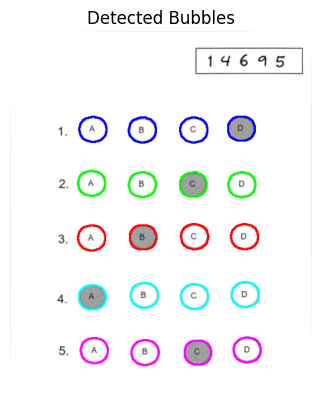

In [98]:
# Sort bubble contours by their y-coordinate
bubble_cnts = sorted(bubble_cnts, key=lambda x: cv2.boundingRect(x)[1])

# Assign a color to each question
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

# Draw contours with different colors for different questions
for i, color in enumerate(colors):
    question_bubbles = bubble_cnts[i*4:(i+1)*4]
    cv2.drawContours(paper, question_bubbles, -1, color, 2)

# Visualize contours
plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
plt.title("Detected Bubbles")
plt.axis('off')
plt.show()


## Installing easyOCR


In [99]:
pip install easyocr

## Student Number Detection

Detected Student Numbers: ['4 6', '9 5']


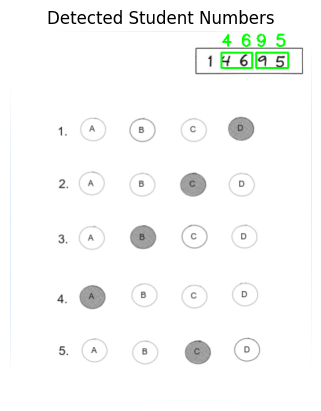

In [100]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Load the image and preprocess
image_path = "/content/drive/MyDrive/bubble9.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhancing contrast using histogram equalization
equalized = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 150)

# Find contours and detect document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            docCnt = approx
            break

if docCnt is not None:
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped_gray = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)

    # Detects the rectangle for student number (assuming it's at the top right corner)
    (h, w) = paper.shape[:2]
    roi = paper[0:int(h * 0.1), int(w * 0.7):w]

    # Uses EasyOCR to detect the numbers in the ROI
    ocr_result = reader.readtext(roi)
    detected_numbers = []
    for (bbox, text, prob) in ocr_result:
        if prob > 0.5:  # Confidence threshold
            detected_numbers.append(text)

    print("Detected Student Numbers:", detected_numbers)

    # Draw bounding boxes around detected text
    for (bbox, text, prob) in ocr_result:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = (int(top_left[0] + int(w * 0.7)), int(top_left[1]))
        bottom_right = (int(bottom_right[0] + int(w * 0.7)), int(bottom_right[1]))
        cv2.rectangle(paper, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(paper, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Visualize the results
    plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
    plt.title("Detected Student Numbers")
    plt.axis('off')
    plt.show()
else:
    print("[ERROR] Could not find the document contour.")


## Checking the Answers

Score: 60.00%


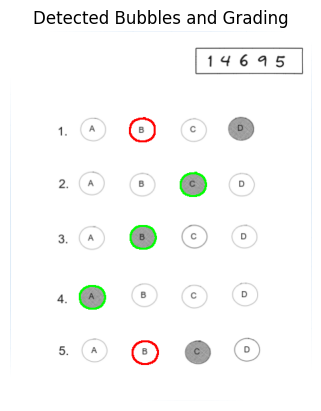

In [101]:
# Defining the answer key
ANSWER_KEY = {0: 1, 1: 2, 2: 1, 3: 0, 4: 1}

# Load the image and preprocess
image_path = "/content/drive/MyDrive/bubble9.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhance contrast using histogram equalization
equalized = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 150)

# Finds contours and detect document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            docCnt = approx
            break

if docCnt is not None:
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped_gray = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)

    # Enhance contrast again after perspective transform
    equalized = cv2.equalizeHist(warped_gray)
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
    edged = cv2.Canny(blurred, 50, 150)

    # Threshold the warped gray image to get a binary image
    thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY_INV)[1]

    # Find contours in the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Filter out contours that correspond to bubbles
    bubble_cnts = []
    for c in cnts:
        (x, y, w, h) = cv2.boundingRect(c)
        aspect_ratio = w / float(h)
        area = cv2.contourArea(c)

        # Bubbles should have a roughly square shape, reasonable area, and specific circularity
        if 0.8 <= aspect_ratio <= 1.2 and 200 < area < 1500:
            circularity = (4 * np.pi * area) / (cv2.arcLength(c, True) ** 2)
            if circularity > 0.7:
                bubble_cnts.append(c)

    # Sort bubble contours by their y-coordinate
    bubble_cnts = contours.sort_contours(bubble_cnts, method="top-to-bottom")[0]

    correct = 0

    # Each question has 4 possible answers, so it loop over the question in batches of 4
    for (q, i) in enumerate(range(0, min(len(cnts), len(ANSWER_KEY) * 4), 4)):
        # Sort the contours for the current question from left to right
        cnts = contours.sort_contours(bubble_cnts[i:i + 4])[0]
        bubbled = None

        # Loop through each sorted contour and apply the mask to find the filled bubble
        for (j, c) in enumerate(cnts):
            mask = np.zeros(thresh.shape, dtype="uint8")
            cv2.drawContours(mask, [c], -1, 255, -1)
            mask = cv2.bitwise_and(thresh, thresh, mask=mask)
            total = cv2.countNonZero(mask)

            if bubbled is None or total > bubbled[0]:
                bubbled = (total, j)

        # Compare the bubbled answer to the correct answer
        color = (0, 0, 255)  # Red for incorrect answer
        k = ANSWER_KEY[q]
        if bubbled[1] == k:
            color = (0, 255, 0)  # Green for correct answer
            correct += 1

        # Draw the outline of the correct answer on the test
        cv2.drawContours(paper, [cnts[k]], -1, color, 2)

    # Calculates the score
    score = (correct / len(ANSWER_KEY)) * 100
    print(f"Score: {score:.2f}%")

    # Visualize contours
    plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
    plt.title("Detected Bubbles and Grading")
    plt.axis('off')
    plt.show()
else:
    print("[ERROR] Could not find the document contour.")


## Printing out the Student Number and the Corresponding Score

In [102]:
print("Detected Student Numbers:", detected_numbers)
print(f"Score: {score:.2f}%")

Detected Student Numbers: ['4 6', '9 5']
Score: 60.00%


##  Final code

- Detects exam and predicts the student number  with their score.
- Saving the results to .csv file(**Student Number: Marks obtained**)


Detected Student Numbers: 4 6 9 5
Score: 60.00%


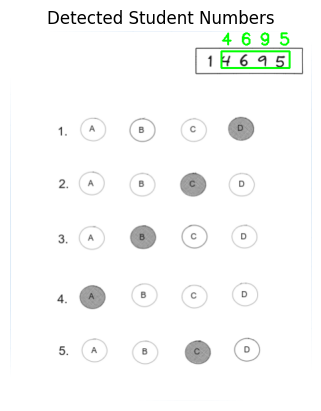

Results saved to results.csv


In [103]:
# Initializing EasyOCR reader
reader = easyocr.Reader(['en'])

# Load the image and preprocess
image_path = "/content/drive/MyDrive/bubble9.png"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Enhance contrast using histogram equalization
equalized = cv2.equalizeHist(gray)
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 150)

# Find contours and detect document
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
docCnt = None

if len(cnts) > 0:
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            docCnt = approx
            break

if docCnt is not None:
    paper = four_point_transform(image, docCnt.reshape(4, 2))
    warped_gray = cv2.cvtColor(paper, cv2.COLOR_BGR2GRAY)

    # Detect the rectangle for student number (assume it's at the top right corner)
    (h, w) = paper.shape[:2]
    roi = paper[0:int(h * 0.1), int(w * 0.7):w]

    # Preprocess ROI for better OCR results
    roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    roi_blurred = cv2.GaussianBlur(roi_gray, (5, 5), 0)
    roi_thresh = cv2.adaptiveThreshold(roi_blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Use EasyOCR to detect the numbers in the ROI with adjusted settings
    ocr_result = reader.readtext(roi_thresh, detail=1, paragraph=False, contrast_ths=0.7, adjust_contrast=0.5)
    detected_numbers = []
    for (bbox, text, prob) in ocr_result:
        if prob > 0.5:  # Confidence threshold
            detected_numbers.append(text)

    # Assuming `score` is calculated elsewhere in the code
    score = 60  # Replace with actual score calculation

    # Join detected numbers to form the student number
    student_number = ''.join(detected_numbers)

    print("Detected Student Numbers:", student_number)
    print(f"Score: {score:.2f}%")

    # Draw bounding boxes around detected text
    for (bbox, text, prob) in ocr_result:
        (top_left, top_right, bottom_right, bottom_left) = bbox
        top_left = (int(top_left[0] + int(w * 0.7)), int(top_left[1]))
        bottom_right = (int(bottom_right[0] + int(w * 0.7)), int(bottom_right[1]))
        cv2.rectangle(paper, top_left, bottom_right, (0, 255, 0), 2)
        cv2.putText(paper, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # Visualize the results
    plt.imshow(cv2.cvtColor(paper, cv2.COLOR_BGR2RGB))
    plt.title("Detected Student Numbers")
    plt.axis('off')
    plt.show()

    # Save to CSV file
    csv_filename = 'results.csv'
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['sl.no', 'student.no', 'marks'])
        writer.writerow([1, student_number, score])

    print(f"Results saved to {csv_filename}")
else:
    print("[ERROR] Could not find the document contour.")
